Best k: 2


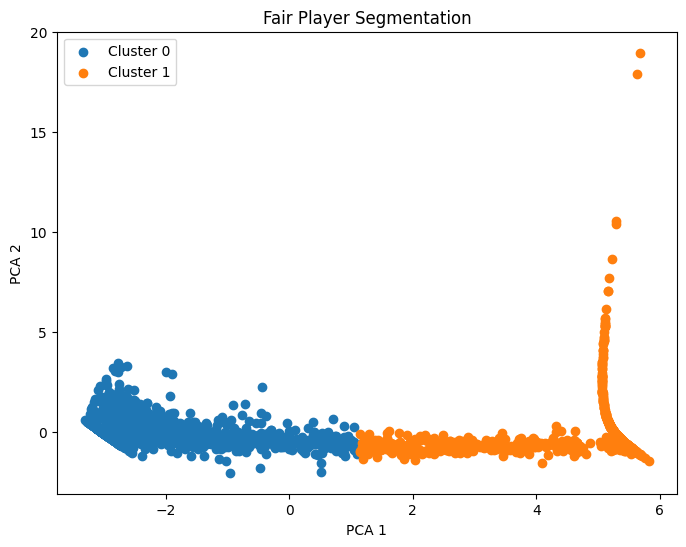

Saved to player_segments_fair.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -------------------------
# Load data
# -------------------------
df = pd.read_csv("player_summary.csv")

# Step 1: Drop unfair percent features
percent_cols = [c for c in df.columns if c.endswith("_percent")]
df = df.drop(columns=percent_cols)

# Step 2: Create fair features
TOTAL_ACHIEVEMENTS = 43

# Engagement: log-capped playtime
df['log_playtime'] = np.log1p(df['playtime_forever'])

# Efficiency: achievements per 10 hours
df['ach_per_10h'] = df['achievement_count'] / (df['playtime_forever'] / 600 + 1e-6)

# Category rank: normalize each category count by its max in dataset
category_counts = [c for c in df.columns if c.endswith("_count") and c not in ['achievement_count', 'death_count']]
for col in category_counts:
    df[col + "_rank"] = df[col] / df[col].max()

# Step 3: Treat max_* as ordinal
max_cols = [c for c in df.columns if c.startswith("max_")]
for col in max_cols:
    df[col + "_ord"] = pd.qcut(df[col], q=3, labels=False, duplicates="drop")

# Step 4: Select final features
exclude_cols = ['steamid', 'playtime_forever', 'achievement_count', 'death_count'] + category_counts + max_cols
features = df.drop(columns=exclude_cols)

# Step 5: Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Step 6: Find optimal k
sil_scores = {}
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores[k] = silhouette_score(X_scaled, labels)
best_k = max(sil_scores, key=sil_scores.get)
print(f"Best k: {best_k}")

# Step 7: Final clustering
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 8: PCA visualization
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
for cluster in range(best_k):
    plt.scatter(coords[df['Cluster'] == cluster, 0],
                coords[df['Cluster'] == cluster, 1],
                label=f"Cluster {cluster}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Fair Player Segmentation")
plt.legend()
plt.show()

# Step 9: Save results
df.to_csv("player_segments_fair.csv", index=False)
print("Saved to player_segments_fair.csv")


In [ ]:
zero_ach = df[df['achievement_count'] == 0]
Q1 = zero_ach['playtime_forever'].quantile(0.25)
Q3 = zero_ach['playtime_forever'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR

df['anomaly_zero_ach_long_play'] = (
    (df['achievement_count'] == 0) &
    (df['playtime_forever'] > upper_limit)
)

print(f"Upper limit for 'normal' 0-achievement playtime: {upper_limit}")
print(df['anomaly_zero_ach_long_play'].sum(), "players flagged as anomaly")

Upper limit for 'normal' 0-achievement playtime: 984.375
55 players flagged as anomaly


In [4]:
# ===========================================================
# 7 Days to Die — Final Pipeline
# Detect anomalies (0-ach long-play) → Fair Features → Re-cluster
# Author: <you>
#
# What it does:
# 1) Loads player_summary.csv
# 2) Flags *data-driven* anomalies: players with 0 achievements but unusually high lifetime playtime (IQR-based)
# 3) Builds "fair" features: drops *_percent, log-caps playtime, achievements per 10h, category count ranks, ordinalized max_*
# 4) Re-clusters only non-anomalies (K selected by silhouette), then appends anomalies with a special label
# 5) Saves:
#    - player_segments_final.csv (clusters + flags + features)
#    - figs/ (PCA plot and elbow/silhouette diagnostics)
#
# Requirements:
#   pip install pandas numpy scikit-learn matplotlib
# ===========================================================

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, Dict, List, Optional

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -------------------------
# Config
# -------------------------
CSV_PATH = "player_summary.csv"   # <- change if needed
RANDOM_STATE = 42
FIG_DIR = "./figs"
os.makedirs(FIG_DIR, exist_ok=True)

# -------------------------
# Helpers
# -------------------------
def iqr_upper_limit(s: pd.Series) -> float:
    """Compute upper whisker using IQR rule (Q3 + 1.5*IQR)."""
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    return float(q3 + 1.5 * iqr)

def safe_qcut_to_ord(series: pd.Series, q: int = 3) -> pd.Series:
    """
    Convert a numeric series to ordinal bins using quantiles.
    Falls back to rank-normalized bins if qcut fails due to low uniques.
    """
    # If all values equal or there are very few unique values, qcut may fail:
    if series.nunique(dropna=True) < 2:
        return pd.Series(0, index=series.index, dtype=int)
    try:
        return pd.qcut(series, q=q, labels=False, duplicates="drop").astype(int)
    except Exception:
        # Fallback: rank then discretize into q bins
        ranks = series.rank(method="average", pct=True)
        bins = np.floor(ranks * q).clip(lower=0, upper=q - 1).astype(int)
        return bins

def build_fair_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, List[str]]:
    """
    Build fair, clustering-ready features:
      - Drop *_percent columns
      - log_playtime = log1p(playtime_forever)
      - ach_per_10h = achievement_count / (playtime_hours/10)
      - *_count_rank = category counts scaled by max within dataset
      - max_* → *_ord via quantile binning (ordinal)
    Returns:
      features_df (with only clustering features)
      feature_names (list)
    """
    work = df.copy()

    # 1) Drop percentage columns (unfair denominators by category)
    percent_cols = [c for c in work.columns if c.endswith("_percent")]
    work.drop(columns=percent_cols, inplace=True, errors="ignore")

    # 2) Core derived features
    work["log_playtime"] = np.log1p(work["playtime_forever"].clip(lower=0))
    # achievements per 10 hours; playtime_forever is minutes
    playtime_hours = work["playtime_forever"].clip(lower=0) / 60.0
    work["ach_per_10h"] = work["achievement_count"] / (playtime_hours / 10.0 + 1e-6)

    # 3) Category count ranks (max-scale within dataset)
    #    Exclude overall counts that aren't category counts
    raw_category_counts = [
        c for c in work.columns
        if c.endswith("_count")
        and c not in ["achievement_count", "death_count"]  # keep death out of fairness by default
    ]
    for col in raw_category_counts:
        col_max = work[col].max()
        work[f"{col}_rank"] = (work[col] / col_max) if col_max > 0 else 0.0

    # 4) Ordinalize max_* single-session features
    max_cols = [c for c in work.columns if c.startswith("max_")]
    for col in max_cols:
        work[f"{col}_ord"] = safe_qcut_to_ord(work[col], q=3)

    # 5) Assemble final features for clustering:
    #    Exclude IDs, raw *_percent, raw *_count, raw max_*, and some raw totals to avoid leakage
    exclude = (
        ["steamid", "playtime_forever", "achievement_count", "death_count"] +
        percent_cols + raw_category_counts + max_cols
    )
    feature_df = work.drop(columns=[c for c in exclude if c in work.columns], errors="ignore")

    # Only keep numeric columns
    feature_df = feature_df.select_dtypes(include=[np.number]).fillna(0.0)

    return feature_df, list(feature_df.columns)

def choose_k_by_silhouette(X: np.ndarray, k_min: int = 2, k_max: int = 8) -> Tuple[int, Dict[int, float]]:
    """
    Choose the best K using silhouette score across [k_min, k_max].
    Requires n_samples > k to compute valid silhouette.
    Returns best_k and the sil score dict.
    """
    n = X.shape[0]
    sil_scores = {}
    best_k = None
    best_score = -np.inf

    for k in range(k_min, min(k_max, n - 1) + 1):
        try:
            km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
            labels = km.fit_predict(X)
            # Need at least 2 clusters with at least 1 sample each; silhouette may error on degenerate cases
            if len(set(labels)) < 2:
                continue
            sil = silhouette_score(X, labels)
            sil_scores[k] = sil
            if sil > best_score:
                best_score = sil
                best_k = k
        except Exception:
            continue

    # If silhouette couldn't find a valid k, default to 3 (if possible), else 2, else 1
    if best_k is None:
        if n >= 3:
            best_k = 3
        elif n == 2:
            best_k = 2
        else:
            best_k = 1  # edge case

    return best_k, sil_scores

def plot_silhouette_curve(sil_scores: Dict[int, float], path: str):
    if not sil_scores:
        return
    K = sorted(sil_scores.keys())
    V = [sil_scores[k] for k in K]
    plt.figure(figsize=(7, 5))
    plt.plot(K, V, marker="o")
    plt.title("Silhouette vs K")
    plt.xlabel("K")
    plt.ylabel("Silhouette Score")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(path)
    plt.close()

def pca_scatter(X: np.ndarray, labels: np.ndarray, title: str, path: str):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    coords = pca.fit_transform(X)
    plt.figure(figsize=(8, 6))
    for lab in sorted(np.unique(labels)):
        mask = labels == lab
        plt.scatter(coords[mask, 0], coords[mask, 1], label=f"Cluster {lab}")
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.tight_layout()
    plt.savefig(path)
    plt.close()

# -------------------------
# 1) Load
# -------------------------
df = pd.read_csv(CSV_PATH)

# Basic sanity: ensure required columns exist
required_cols = ["steamid", "playtime_forever", "achievement_count"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required column(s): {missing}")

# -------------------------
# 2) Data-driven anomaly flag:
#     "0 achievements" with unusually high total playtime (IQR rule within that subgroup)
# -------------------------
zero_ach = df[df["achievement_count"] == 0]
if len(zero_ach) >= 5:
    upper_limit = iqr_upper_limit(zero_ach["playtime_forever"].clip(lower=0))
else:
    # If too few zero-ach players to get a stable IQR, be conservative and set no anomalies.
    upper_limit = np.inf

df["anomaly_zero_ach_long_play"] = (
    (df["achievement_count"] == 0) &
    (df["playtime_forever"].clip(lower=0) > upper_limit)
)

# -------------------------
# 3) Fair feature engineering
# -------------------------
features_all, feature_names = build_fair_features(df)

# -------------------------
# 4) Two-phase clustering:
#    A) Cluster NON-anomalies
#    B) Append anomalies with special label (-1)
# -------------------------
non_anom_mask = ~df["anomaly_zero_ach_long_play"]
X_non = features_all.loc[non_anom_mask].values

# Guard: if non-anomalies are too few to cluster, skip clustering
cluster_labels = np.full(df.shape[0], fill_value=-1, dtype=int)  # default label for anomalies & edge cases

if X_non.shape[0] >= 5:
    scaler = StandardScaler()
    X_non_scaled = scaler.fit_transform(X_non)

    # Choose K by silhouette (2..8)
    best_k, sil_scores = choose_k_by_silhouette(X_non_scaled, k_min=2, k_max=8)

    # Plot silhouette curve
    plot_silhouette_curve(sil_scores, os.path.join(FIG_DIR, "silhouette_vs_k.png"))

    # Final KMeans on non-anomalies
    if best_k > 1 and X_non_scaled.shape[0] >= best_k:
        km = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
        labels_non = km.fit_predict(X_non_scaled)

        # Assign back
        cluster_labels[non_anom_mask.values] = labels_non

        # PCA scatter for clustered set (non-anomalies)
        pca_scatter(
            X_non_scaled,
            labels_non,
            title=f"Fair Clustering (non-anomalies) — K={best_k}",
            path=os.path.join(FIG_DIR, "pca_clusters_non_anomalies.png"),
        )

        # Optional: PCA showing anomalies as -1 (if you want a combined view)
        # Scale all using same scaler (transform anomalies too)
        X_all_scaled = scaler.transform(features_all.values[non_anom_mask.index])
        # Create combined labels (already set cluster_labels)
        pca_scatter(
            X_all_scaled,
            cluster_labels,
            title="Combined PCA (clusters + anomalies)",
            path=os.path.join(FIG_DIR, "pca_clusters_combined.png"),
        )
    else:
        # If silhouette picked 1 or degenerate case, skip KMeans
        best_k = 1
        cluster_labels[non_anom_mask.values] = 0
else:
    best_k = 1
    # Edge case: not enough non-anomalies — label them all as 0, anomalies as -1
    cluster_labels[non_anom_mask.values] = 0

# -------------------------
# 5) Output & summaries
# -------------------------
out = df.copy()
out["Cluster"] = cluster_labels

# Attach a compact feature set for inspection (optional: comment out if you want lean CSV)
for col in feature_names:
    out[f"feat_{col}"] = features_all[col].values

out_path = "player_segments_final.csv"
out.to_csv(out_path, index=False)

# Print concise report
n_total = len(out)
n_anom = int(out["anomaly_zero_ach_long_play"].sum())
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

print("===============================================")
print("Pipeline completed.")
print(f"Saved clustered data to: {out_path}")
print(f"Figures saved under: {FIG_DIR}/")
print("-----------------------------------------------")
print(f"Total players: {n_total}")
print(f"Anomaly (0-ach, long-play) flagged: {n_anom}")
print(f"Clusters (excluding anomalies): {n_clusters}")
print("-----------------------------------------------")
print("Cluster sizes (including anomalies label -1):")
print(out["Cluster"].value_counts(dropna=False).sort_index())
print("-----------------------------------------------")
print("Non-anomaly cluster feature means (top 10 by variance):")

# Show top varying features across clusters (non-anomalies)
non_anom = out[out["Cluster"] != -1]
if not non_anom.empty and non_anom["Cluster"].nunique() >= 1:
    feat_cols = [f"feat_{c}" for c in feature_names]
    # Pick top 10 features by variance to summarize
    var_order = non_anom[feat_cols].var().sort_values(ascending=False).head(10).index.tolist()
    summary = non_anom.groupby("Cluster")[var_order].mean().round(3)
    print(summary)
else:
    print("Not enough non-anomaly clustered data to summarize.")

# -------------------------
# End
# -------------------------


Pipeline completed.
Saved clustered data to: player_segments_final.csv
Figures saved under: ./figs/
-----------------------------------------------
Total players: 2306
Anomaly (0-ach, long-play) flagged: 55
Clusters (excluding anomalies): 2
-----------------------------------------------
Cluster sizes (including anomalies label -1):
Cluster
-1      55
 0     775
 1    1476
Name: count, dtype: int64
-----------------------------------------------
Non-anomaly cluster feature means (top 10 by variance):
         feat_ach_per_10h  feat_log_playtime  feat_max_items_crafted_ord  \
Cluster                                                                    
0                  13.459              8.950                       0.920   
1                   6.920              6.306                       0.033   

         feat_max_death_count_ord  feat_max_death_count_rank_ord  \
Cluster                                                            
0                           0.886                    

In [5]:
# ===========================================================
# 7 Days to Die — Full ML Pipeline
# Clustering → Classification → Regression → Evaluation
# Author: <you>
#
# Requirements:
#   pip install pandas numpy scikit-learn matplotlib
# ===========================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

# -------------------------
# Config
# -------------------------
CSV_PATH = "player_summary.csv"
RANDOM_STATE = 42
FIG_DIR = "./figs"
os.makedirs(FIG_DIR, exist_ok=True)

# -------------------------
# Helper Functions
# -------------------------
def iqr_upper_limit(s: pd.Series) -> float:
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    return float(q3 + 1.5 * iqr)

def safe_qcut_to_ord(series: pd.Series, q: int = 3) -> pd.Series:
    if series.nunique(dropna=True) < 2:
        return pd.Series(0, index=series.index, dtype=int)
    try:
        return pd.qcut(series, q=q, labels=False, duplicates="drop").astype(int)
    except Exception:
        ranks = series.rank(method="average", pct=True)
        bins = np.floor(ranks * q).clip(lower=0, upper=q - 1).astype(int)
        return bins

def build_fair_features(df: pd.DataFrame):
    work = df.copy()
    percent_cols = [c for c in work.columns if c.endswith("_percent")]
    work.drop(columns=percent_cols, inplace=True, errors="ignore")
    work["log_playtime"] = np.log1p(work["playtime_forever"].clip(lower=0))
    playtime_hours = work["playtime_forever"].clip(lower=0) / 60.0
    work["ach_per_10h"] = work["achievement_count"] / (playtime_hours / 10.0 + 1e-6)
    raw_category_counts = [
        c for c in work.columns
        if c.endswith("_count") and c not in ["achievement_count", "death_count"]
    ]
    for col in raw_category_counts:
        col_max = work[col].max()
        work[f"{col}_rank"] = (work[col] / col_max) if col_max > 0 else 0.0
    max_cols = [c for c in work.columns if c.startswith("max_")]
    for col in max_cols:
        work[f"{col}_ord"] = safe_qcut_to_ord(work[col], q=3)
    exclude = (
        ["steamid", "playtime_forever", "achievement_count", "death_count"] +
        percent_cols + raw_category_counts + max_cols
    )
    feature_df = work.drop(columns=[c for c in exclude if c in work.columns], errors="ignore")
    feature_df = feature_df.select_dtypes(include=[np.number]).fillna(0.0)
    return feature_df, list(feature_df.columns)

def choose_k_by_silhouette(X: np.ndarray, k_min: int = 2, k_max: int = 8):
    n = X.shape[0]
    sil_scores = {}
    best_k, best_score = None, -np.inf
    for k in range(k_min, min(k_max, n - 1) + 1):
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = km.fit_predict(X)
        if len(set(labels)) < 2:
            continue
        sil = silhouette_score(X, labels)
        sil_scores[k] = sil
        if sil > best_score:
            best_score, best_k = sil, k
    if best_k is None:
        best_k = 2
    return best_k, sil_scores

# -------------------------
# 1. Load & Anomaly Detection
# -------------------------
df = pd.read_csv(CSV_PATH)
zero_ach = df[df["achievement_count"] == 0]
if len(zero_ach) >= 5:
    upper_limit = iqr_upper_limit(zero_ach["playtime_forever"].clip(lower=0))
else:
    upper_limit = np.inf
df["anomaly_zero_ach_long_play"] = (
    (df["achievement_count"] == 0) &
    (df["playtime_forever"].clip(lower=0) > upper_limit)
)

# -------------------------
# 2. Fair Feature Engineering
# -------------------------
features_all, feature_names = build_fair_features(df)

# -------------------------
# 3. Clustering (Personas)
# -------------------------
non_anom_mask = ~df["anomaly_zero_ach_long_play"]
X_non = features_all.loc[non_anom_mask].values
scaler = StandardScaler()
X_non_scaled = scaler.fit_transform(X_non)
best_k, sil_scores = choose_k_by_silhouette(X_non_scaled, k_min=2, k_max=8)
km = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
labels_non = km.fit_predict(X_non_scaled)
cluster_labels = np.full(df.shape[0], fill_value=-1, dtype=int)
cluster_labels[non_anom_mask.values] = labels_non
df["Cluster"] = cluster_labels
print(f"Clustering done. Best k: {best_k}, Silhouette scores: {sil_scores}")

# -------------------------
# 4. Classification: Predict Cluster
# -------------------------
clf_X = features_all[non_anom_mask]
clf_y = df.loc[non_anom_mask, "Cluster"]
X_train, X_test, y_train, y_test = train_test_split(clf_X, clf_y, test_size=0.2, random_state=RANDOM_STATE, stratify=clf_y)
clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("\n=== Classification Report (Predicting Persona) ===")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
importances = pd.Series(clf.feature_importances_, index=clf_X.columns).sort_values(ascending=False)
importances.head(10).plot(kind="barh", title="Top 10 Classification Feature Importances")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "classification_feature_importances.png"))
plt.close()

# -------------------------
# 5. Regression: Predict Achievement Count
# -------------------------
reg_X = features_all
reg_y = df["achievement_count"]
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(reg_X, reg_y, test_size=0.2, random_state=RANDOM_STATE)
reg = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE)
reg.fit(X_train_r, y_train_r)
y_pred_r = reg.predict(X_test_r)
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
r2 = r2_score(y_test_r, y_pred_r)
print("\n=== Regression Report (Predicting Achievement Count) ===")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")
reg_importances = pd.Series(reg.feature_importances_, index=reg_X.columns).sort_values(ascending=False)
reg_importances.head(10).plot(kind="barh", title="Top 10 Regression Feature Importances")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "regression_feature_importances.png"))
plt.close()

# -------------------------
# 6. Save Final Data
# -------------------------
df_out = df.copy()
for col in feature_names:
    df_out[f"feat_{col}"] = features_all[col].values
df_out.to_csv("player_segments_with_models.csv", index=False)
print("\nPipeline complete. Outputs saved:")
print(f"- Clustered + model data: player_segments_with_models.csv")
print(f"- Figures in: {FIG_DIR}/")


Clustering done. Best k: 2, Silhouette scores: {2: np.float64(0.6336071438229751), 3: np.float64(0.5401976965946252), 4: np.float64(0.542876222397428), 5: np.float64(0.53051170119202), 6: np.float64(0.4891850417819198), 7: np.float64(0.48844653865006404), 8: np.float64(0.4496423063282944)}

=== Classification Report (Predicting Persona) ===
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       155
           1       0.99      0.99      0.99       296

    accuracy                           0.99       451
   macro avg       0.99      0.98      0.99       451
weighted avg       0.99      0.99      0.99       451

Accuracy: 0.987

=== Regression Report (Predicting Achievement Count) ===
RMSE: 0.732
R²: 0.998

Pipeline complete. Outputs saved:
- Clustered + model data: player_segments_with_models.csv
- Figures in: ./figs/
